In [147]:
#Using Google Colab : Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score,accuracy_score,classification_report,roc_curve,confusion_matrix
from sklearn.feature_selection import chi2, f_classif
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.decomposition import PCA 
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_validate
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

##Problem Statement

To predict an integer classification for the forest cover type. 
```

The problem statement revolves around the need to predict the forest cover type (the predominant kind of tree cover)
from strictly cartographic variables (as opposed to remotely sensed data). 

It includes four wilderness areas located in the Roosevelt National Forest of northern Colorado.
These areas represent forests with minimal human-caused disturbances, so that existing forest cover types are more a result of ecological processes rather than forest management practices.

The study area includes four wilderness areas located in the Roosevelt National Forest of northern Colorado.
Each observation is a 30m x 30m patch. You are asked to predict an integer classification for the forest cover type. 

Spruce/Fir
Lodgepole Pine
Ponderosa Pine
Cottonwood/Willow
Aspen
Douglas-fir
Krummholz
```

In [149]:
#Feature Description
feat_desc=pd.read_excel('/content/drive/MyDrive/Forest Type Cover Prediction/FCDataDictionary.xlsx')
feat_desc

,Feature,Description
0,Elevation,Elevation in meters
1,Aspect,Aspect in degrees azimuth
2,Slope,Slope in degrees
3,Horizontal Distance To Hydrology,Horz Dist to nearest surface water features
4,Vertical Distance To Hydrology,Vertical Distance to nearest surface water fea...
5,Horizontal Distance To Roadways,Horizontal Distance to nearest roadway
6,Hillshade_9am (0 to 255 index),"Hillshade index at 9am, summer solstice"
7,Hillshade_Noon (0 to 255 index),"Hillshade index at noon, summer solstice"
8,Hillshade_3pm (0 to 255 index),"Hillshade index at 3pm, summer solstice"
9,Horizontal Distance To Fire Points,Horizontal Dist to nearest wildfire ignition p...


### Load the dataset



In [150]:
# read the dataset and extract the test  and train data separately
df_train=pd.read_csv('/content/drive/MyDrive/Forest Type Cover Prediction/train.csv')
df_test=pd.read_csv('/content/drive/MyDrive/Forest Type Cover Prediction/test.csv')

#Dropping df_train Id column : train_id
train_id = df_train['Id']
df_train.drop(['Id'], axis=1, inplace=True)

In [151]:
#First look at data
df_train.head(10)


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2744,96,17,30,-7,458,245,214,92,351,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5
1,2504,103,8,30,6,404,234,230,127,1510,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6
2,2311,30,7,0,0,1230,218,226,143,150,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
3,2710,191,26,443,-45,1209,210,249,158,939,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
4,2802,91,11,540,18,1699,237,223,115,1084,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
5,2075,282,28,95,71,247,133,229,230,531,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
6,3146,291,10,30,-6,4362,192,239,186,3477,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
7,2872,229,17,108,-13,1869,192,253,195,1476,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5
8,3166,165,17,67,9,1412,233,243,136,693,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,7
9,2130,38,5,30,-6,1250,220,228,144,1371,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4


In [152]:
# Data shape and columns
print(df_train.shape)
print(df_train.columns)

(9072, 55)
Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', '

In [153]:
df_train.info()

# No missing data 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9072 entries, 0 to 9071
Data columns (total 55 columns):
 #   Column                              Non-Null Count  Dtype
---  ------                              --------------  -----
 0   Elevation                           9072 non-null   int64
 1   Aspect                              9072 non-null   int64
 2   Slope                               9072 non-null   int64
 3   Horizontal_Distance_To_Hydrology    9072 non-null   int64
 4   Vertical_Distance_To_Hydrology      9072 non-null   int64
 5   Horizontal_Distance_To_Roadways     9072 non-null   int64
 6   Hillshade_9am                       9072 non-null   int64
 7   Hillshade_Noon                      9072 non-null   int64
 8   Hillshade_3pm                       9072 non-null   int64
 9   Horizontal_Distance_To_Fire_Points  9072 non-null   int64
 10  Wilderness_Area1                    9072 non-null   int64
 11  Wilderness_Area2                    9072 non-null   int64
 12  Wilder

In [154]:
# Describe data
df_train.describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
count,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.0,9072.000000,9072.000000,9072.000000,9072.000000,9072.00000,9072.000000,9072.000000,9072.0,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.00000
mean,2749.531415,156.480930,16.529872,226.781966,51.213624,1717.954806,212.691027,219.030423,135.119378,1520.420525,0.239528,0.032959,0.420084,0.307429,0.025022,0.040675,0.061728,0.055004,0.010913,0.045635,0.0,0.000110,0.000551,0.138117,0.026675,0.01455,0.033069,0.011243,0.0,0.007716,0.040344,0.004740,0.003086,0.009700,0.001102,0.022707,0.049824,0.015322,0.000110,0.003968,0.000882,0.000551,0.086530,0.048721,0.020944,0.045635,0.041005,0.001653,0.006834,0.000551,0.002425,0.048391,0.044312,0.029652,4.00000
std,417.236330,109.411024,8.495603,208.875071,61.621329,1322.812625,30.720175,22.885044,46.225735,1121.444963,0.426819,0.178538,0.493599,0.461454,0.156201,0.197546,0.240675,0.228001,0.103898,0.208704,0.0,0.010499,0.023471,0.345042,0.161142,0.11975,0.178826,0.105443,0.0,0.087506,0.196775,0.068687,0.055473,0.098016,0.033184,0.148977,0.217592,0.122836,0.010499,0.062872,0.029684,0.023471,0.281161,0.215297,0.143203,0.208704,0.198313,0.040631,0.082391,0.023471,0.049188,0.214602,0.205799,0.169634,2.00011
min,1863.000000,0.000000,0.000000,0.000000,-123.000000,0.000000,0.000000,99.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000
25%,2375.750000,65.000000,10.000000,67.000000,5.000000,765.000000,196.000000,207.000000,106.000000,730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.00000
50%,2755.000000,125.000000,15.000000,180.000000,32.000000,1321.000000,220.000000,223.000000,138.000000,1252.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.00000
75%,3099.000000,258.250000,22.000000,324.000000,80.000000,2263.000000,235.000000,

### EDA & Data Preprocessing

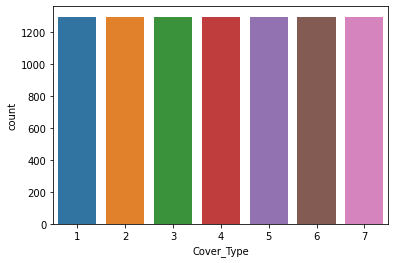

In [155]:
sns.countplot(x='Cover_Type', data=df_train)
#Balanced Categories

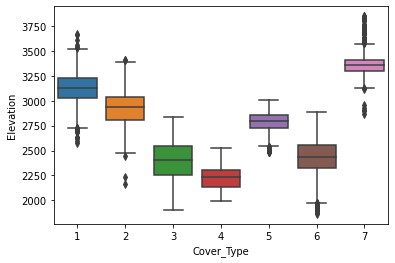

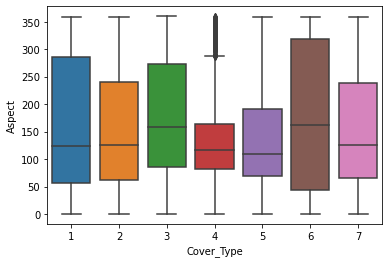

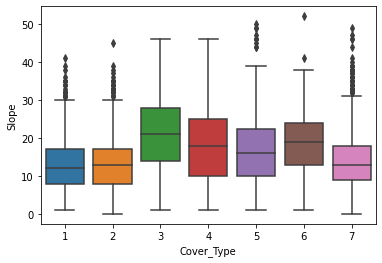

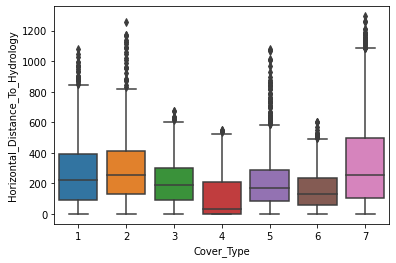

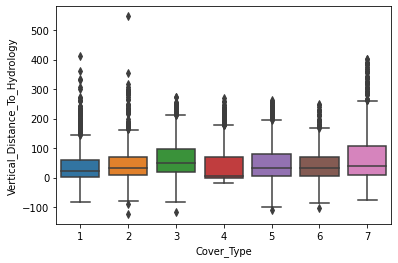

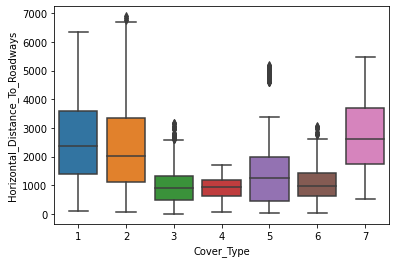

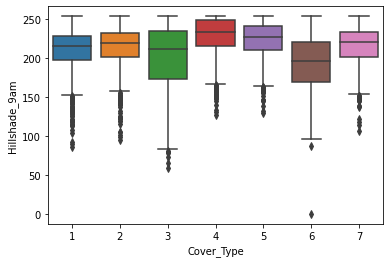

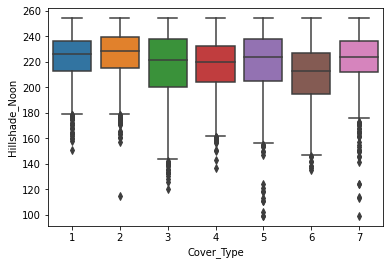

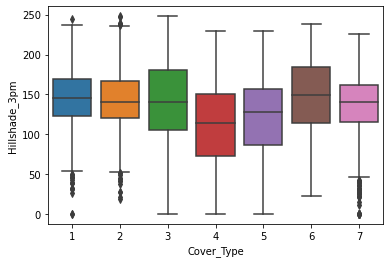

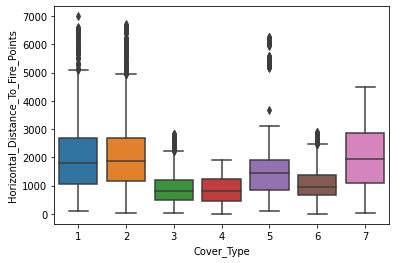

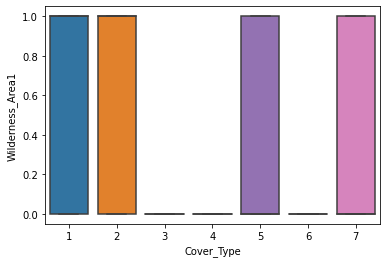

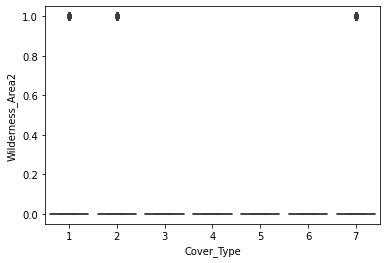

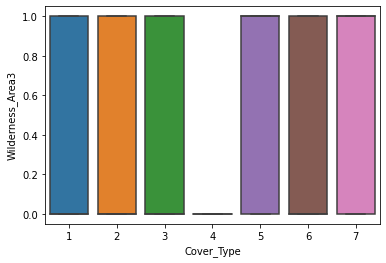

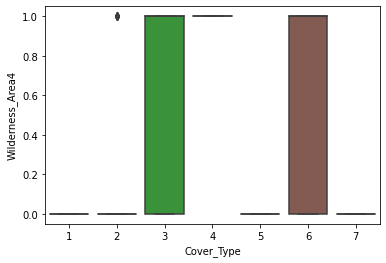

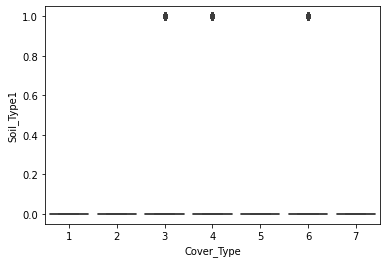

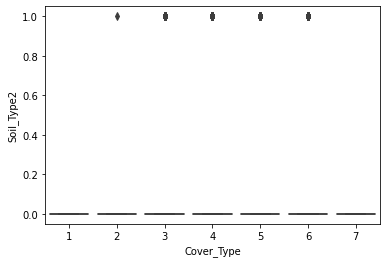

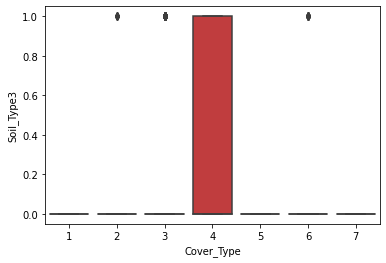

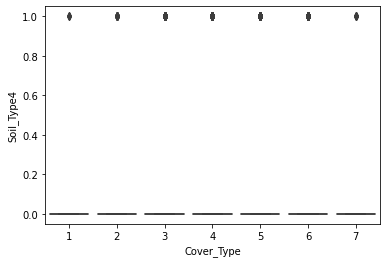

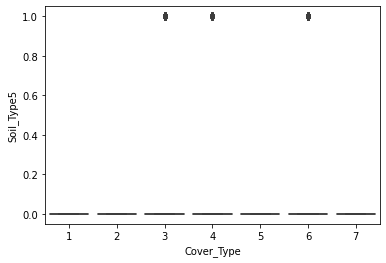

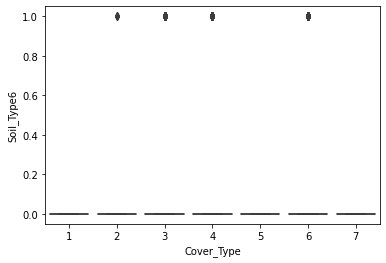

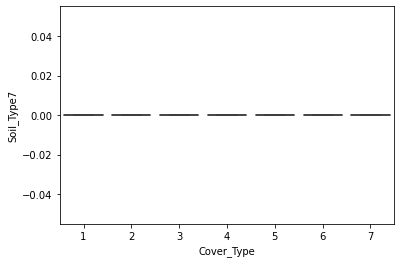

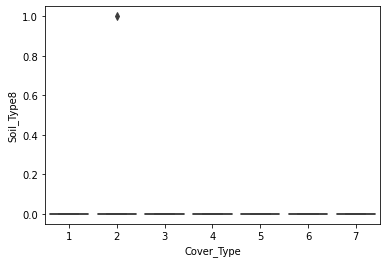

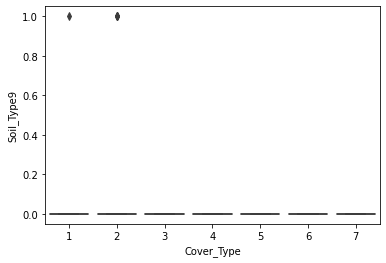

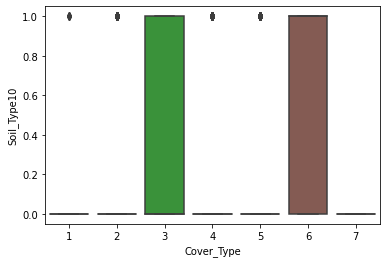

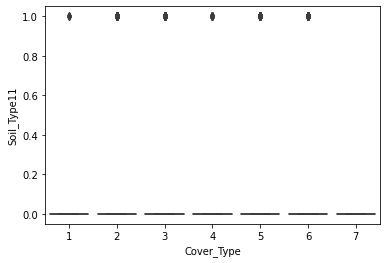

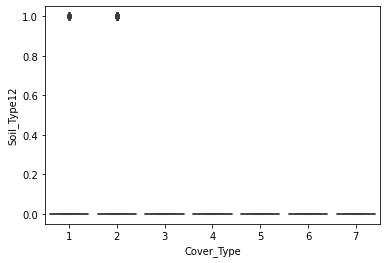

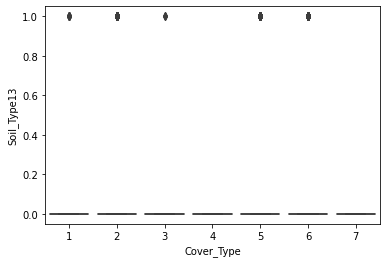

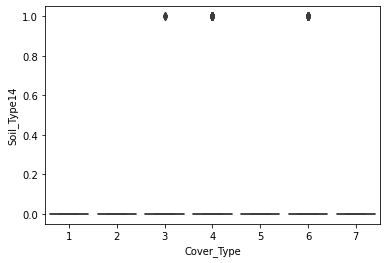

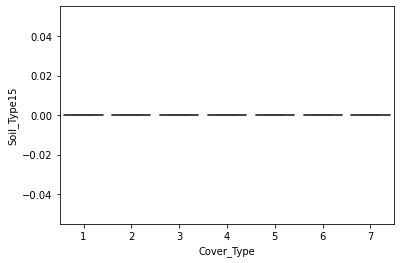

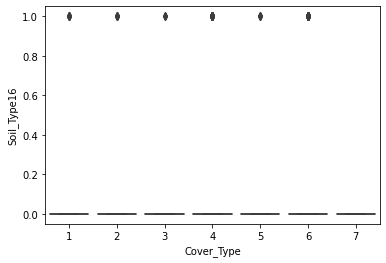

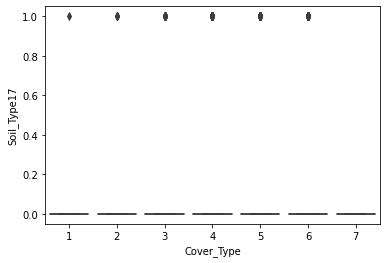

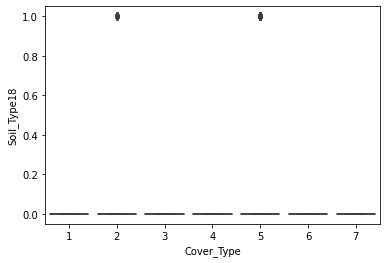

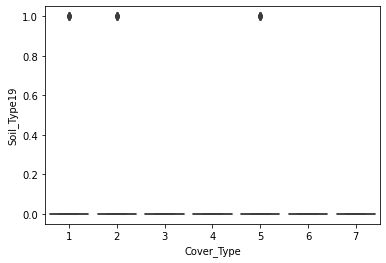

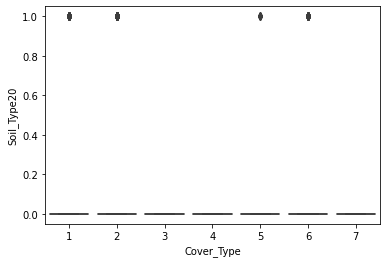

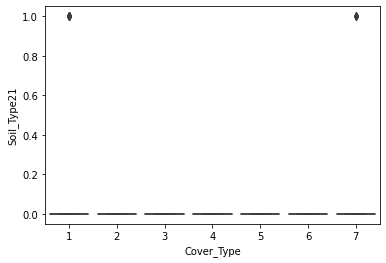

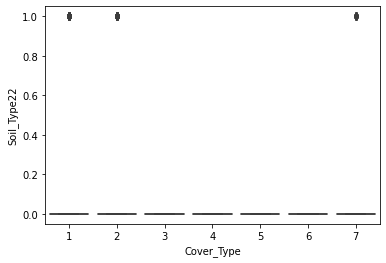

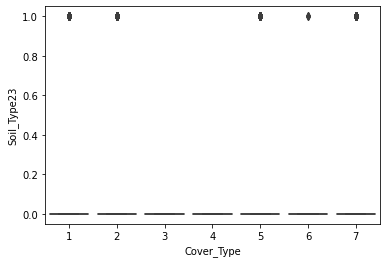

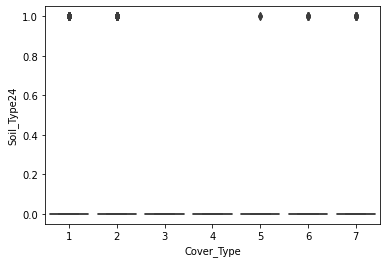

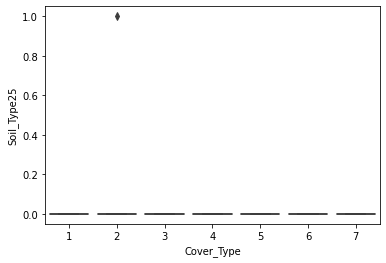

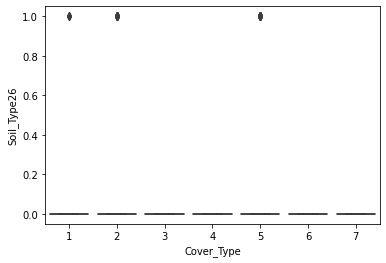

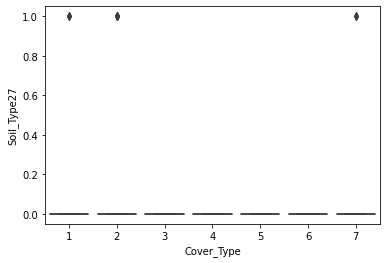

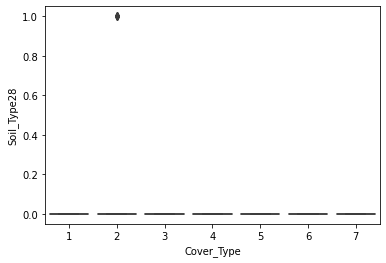

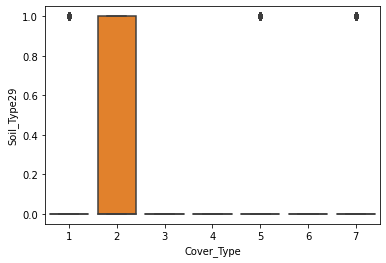

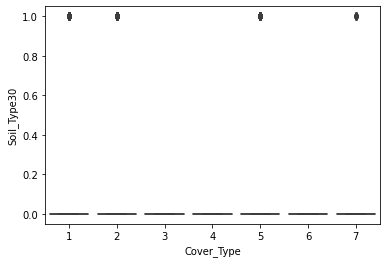

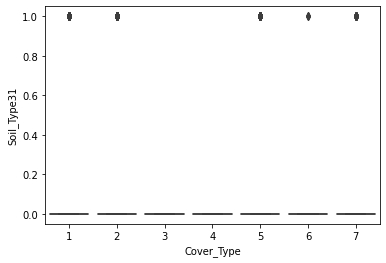

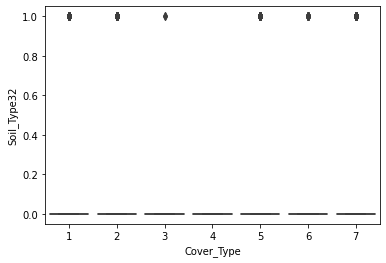

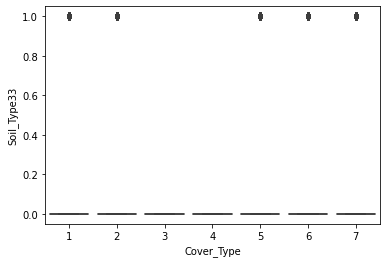

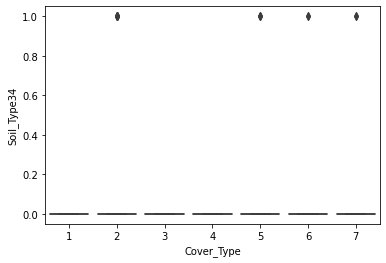

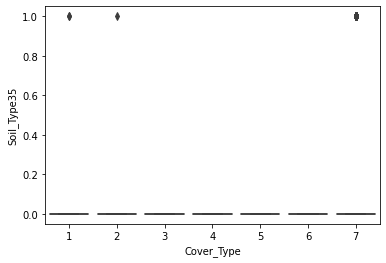

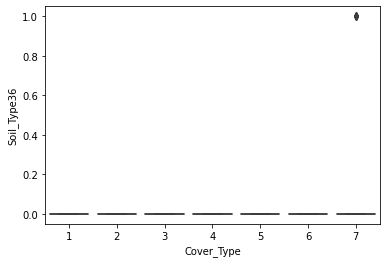

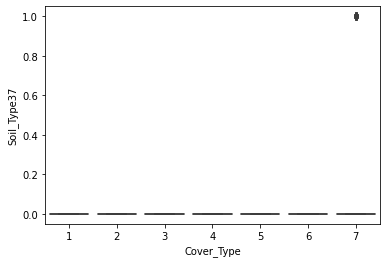

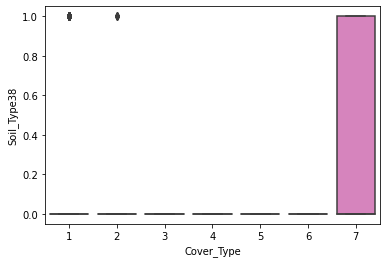

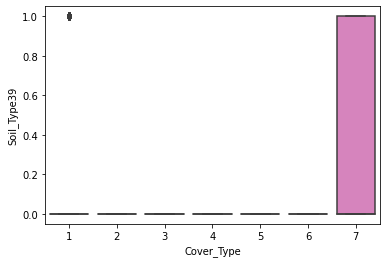

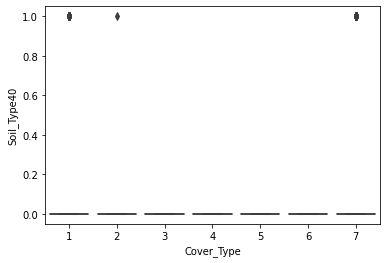

In [156]:
#Boxplot target vs features
cols = df_train.columns

for i in range(0,54):
      sns.boxplot(x=df_train['Cover_Type'], y=df_train[cols[i]])
      plt.show()

#Obs: No relation between target and Soil_Type7(all 0), Soil_Type15(all 0) 

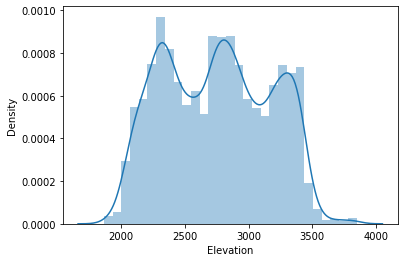

In [157]:
#Elevation
sns.distplot(df_train['Elevation'])

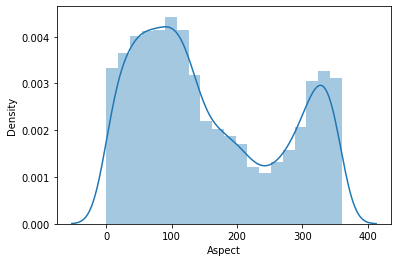

In [158]:
#Aspect
sns.distplot(df_train['Aspect'])

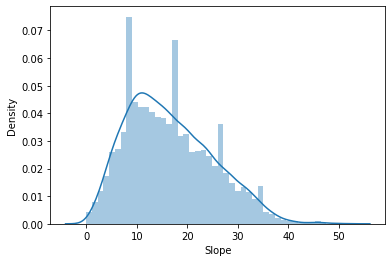

In [159]:
#Slope
sns.distplot(df_train['Slope'])

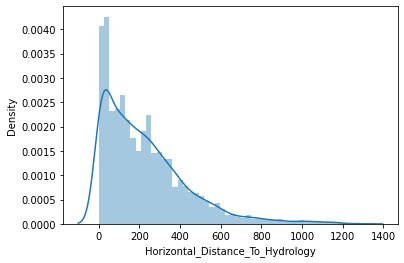

In [160]:
#Horizontal_Distance_To_Hydrology
sns.distplot(df_train['Horizontal_Distance_To_Hydrology'])

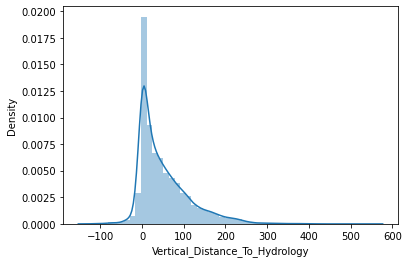

In [161]:
#Vertical_Distance_To_Hydrology
sns.distplot(df_train['Vertical_Distance_To_Hydrology'])

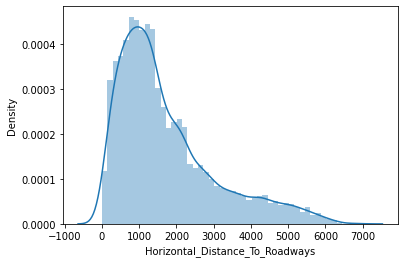

In [162]:
#Horizontal_Distance_To_Roadways
sns.distplot(df_train['Horizontal_Distance_To_Roadways'])

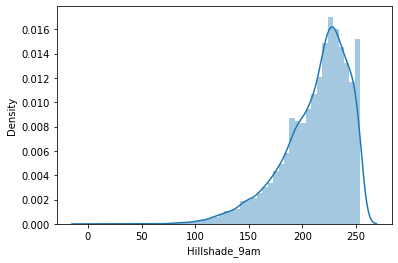

In [163]:
#Hillshade_9am
sns.distplot(df_train['Hillshade_9am'])

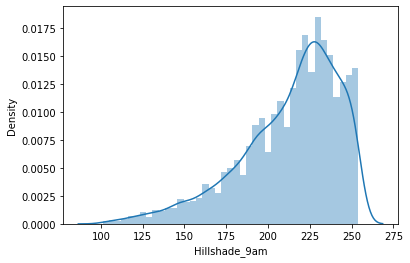

In [164]:
#Hillshade_9am
df_train = df_train[df_train['Hillshade_9am'] > 100] #Acc - 71 7o 73
sns.distplot(df_train['Hillshade_9am'])

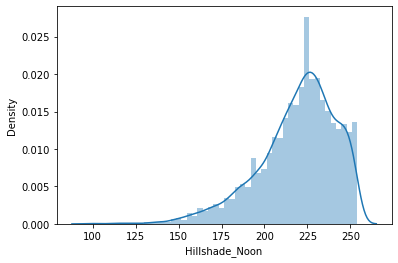

In [165]:
#Hillshade_Noon
sns.distplot(df_train['Hillshade_Noon'])

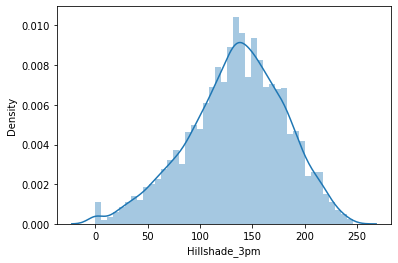

In [166]:
#Hillshade_3pm
sns.distplot(df_train['Hillshade_3pm'])

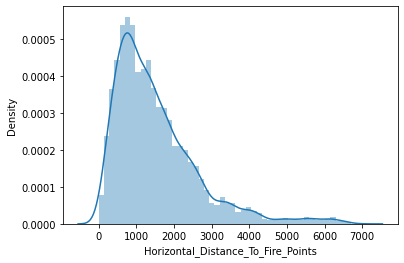

In [167]:
#Horizontal_Distance_To_Fire_Points
sns.distplot(df_train['Horizontal_Distance_To_Fire_Points'])

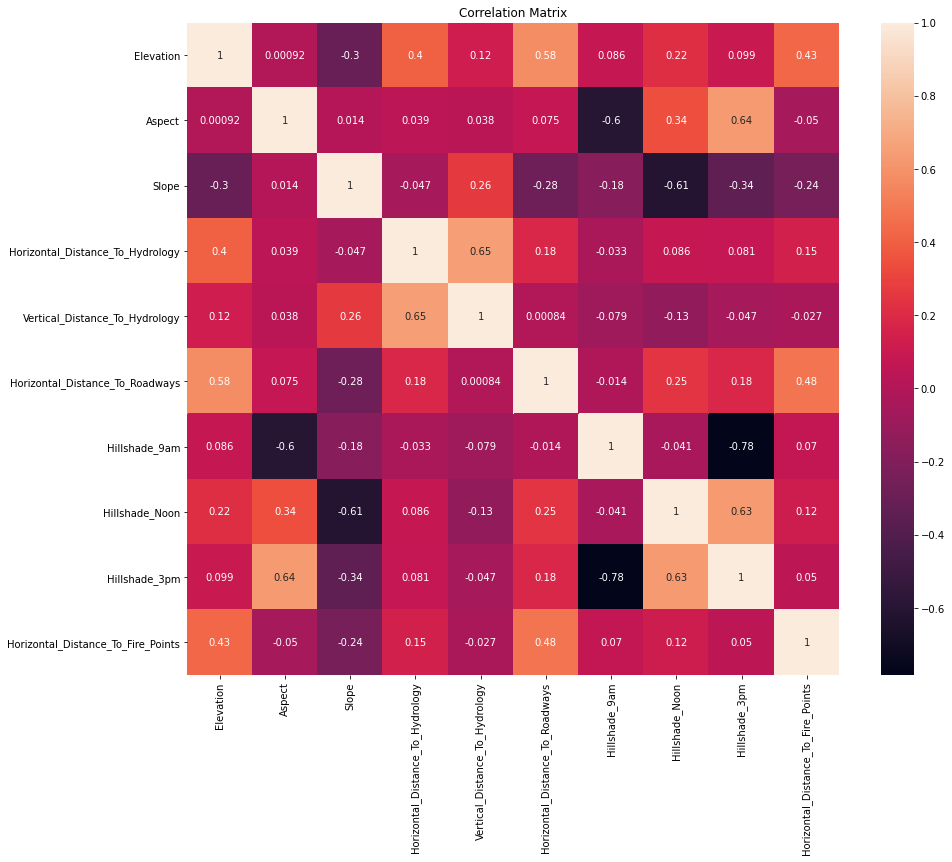

In [168]:
# correlation
corr = df_train.iloc[:,:10].corr()

plt.figure(figsize=(15,12))
plt.title('Correlation Matrix')

sns.heatmap(corr,square=True,annot = True)
plt.show();


### Feature Selection and Model building

In [169]:
#Splitting training set
X=df_train[['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points','Wilderness_Area1',
        'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
        'Soil_Type1','Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type8','Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
        'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40']]
       
y=df_train['Cover_Type']


In [170]:
#we split 75% of the data to training set while 25% of the data to validation 
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=0)

#X_train, X_valid shape
print(X_train.shape)
print(X_valid.shape)


(6783, 52)
(2262, 52)


In [171]:
#Standardization

cols = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points']

scaler = StandardScaler()
scaler.fit(X_train[cols])

X_train[cols] = scaler.transform(X_train[cols])
X_valid[cols] = scaler.transform(X_valid[cols])


In [172]:
# fit the model
logreg = OneVsRestClassifier(LogisticRegression(random_state = 42))

logreg.fit(X_train, y_train) 

# making predictions
y_pred = logreg.predict(X_valid)

#Classification report
print("Classification report - \n", classification_report(y_valid,y_pred))

# accuracy
acc = accuracy_score(y_valid, y_pred)
print(acc)


Classification report - 
               precision    recall  f1-score   support

           1       0.66      0.68      0.67       320
           2       0.62      0.53      0.57       332
           3       0.62      0.53      0.57       326
           4       0.80      0.89      0.84       319
           5       0.64      0.72      0.68       303
           6       0.58      0.62      0.60       339
           7       0.90      0.88      0.89       323

    accuracy                           0.69      2262
   macro avg       0.69      0.69      0.69      2262
weighted avg       0.69      0.69      0.69      2262

0.6914235190097259


In [173]:
#Initialising Random Forest model
rf = RandomForestClassifier()

rfecv = RFECV(estimator=rf, step=1, cv=3, scoring='accuracy')   #3-fold cross-validation

# Fit the random search model
rfecv.fit(X_train, y_train)

y_rf_pred= rfecv.predict(X_valid)

#Classification report
print("Classification report - \n", classification_report(y_valid,y_rf_pred))

# accuracy
acc = accuracy_score(y_valid, y_rf_pred)
print(acc)


Classification report - 
               precision    recall  f1-score   support

           1       0.77      0.79      0.78       320
           2       0.79      0.69      0.74       332
           3       0.82      0.83      0.82       326
           4       0.92      0.97      0.94       319
           5       0.91      0.94      0.92       303
           6       0.85      0.84      0.84       339
           7       0.94      0.96      0.95       323

    accuracy                           0.86      2262
   macro avg       0.86      0.86      0.86      2262
weighted avg       0.86      0.86      0.86      2262

0.8576480990274093


In [174]:
print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X_train.columns[rfecv.support_])

Optimal number of features : 28
Best features : Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area3', 'Wilderness_Area4', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type10', 'Soil_Type13', 'Soil_Type17',
       'Soil_Type22', 'Soil_Type23', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type32', 'Soil_Type33', 'Soil_Type38', 'Soil_Type39',
       'Soil_Type40'],
      dtype='object')


### Prediction on the test data and creating the submission file.


In [175]:
#the Id column in a separate variable : Id
test_id = df_test['Id']
df_test.drop(['Id'], axis=1, inplace=True) 

#Test data shape and columns names
print(df_test.shape)
print(df_test.columns)


(6048, 54)
Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', '

In [176]:
#Features selected from test data
X_test=df_test[['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
        'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40']]

#Fitting and transforming the model on X_valid
X_test[cols] = scaler.transform(X_test[cols])

#make prediction : Cover_Type
y_test_pred = rfecv.predict(X_test)

#Making df for submission
subm=pd.DataFrame({"Id": test_id, "Cover_Type": y_test_pred})
print(subm.head())

     Id  Cover_Type
0  6376           5
1  8962           7
2  7122           5
3   931           5
4  3678           6


In [177]:
# To CSV for submission
subm.to_csv('Cover_Type.csv',index=False)

#from google.colab import files
#files.download('Cover_Type.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>